In [ ]:
import os, glob, warnings
import numpy as np
import pandas as pd
import cv2
import numpy as np
import librosa
import moviepy.editor as mp
from skimage import color
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

warnings.filterwarnings("ignore")

In [5]:
DATA_DIR = "./data"
GT_FILES = glob.glob(os.path.join(DATA_DIR, "*.xlsx"))
VIDEO_FILES = glob.glob(os.path.join(DATA_DIR, "episodes", "*.avi"))
CACHE_FILE = os.path.join(DATA_DIR, "visual_features.npz")

SEED = 12332287
CLASSES = ["MissPiggy", "OtherPigs", "SwedishChef", "Rowlf"]

GT_REQUIRED = [
    "Video", "Frame_number", "Timestamp",
    "Kermit", "Pigs", "Miss Piggy", "Cook",
    "StatlerWaldorf", "Rowlf the Dog", "Fozzie Bear"
]

GT_TO_INTERNAL = {
    "Miss Piggy": "MissPiggy",
    "Pigs": "OtherPigs",
    "Cook": "SwedishChef",
    "Rowlf the Dog": "Rowlf",
}

np.random.seed(SEED)

### Load Ground Truth

In [6]:
def read_ground_truth(gt_dir):
    """reads all ground truth xlsx files and returns df indexed by (Video, Frame_number)"""
    files = sorted(glob.glob(os.path.join(gt_dir, "*.xlsx")))
    if not files:
        raise FileNotFoundError("no ground truth xlsx found in gt_dir")

    dfs = []
    for path in files:
        df = pd.read_excel(path)

        # verify headers
        missing = [c for c in GT_REQUIRED if c not in df.columns]
        if missing:
            raise ValueError(f"{os.path.basename(path)} missing columns: {missing}")

        # enforce numeric dtypes
        df["Video"] = pd.to_numeric(df["Video"], errors="coerce").astype("Int64")
        df["Frame_number"] = pd.to_numeric(df["Frame_number"], errors="coerce").astype("Int64")

        # map exact GT columns to internal class names
        for gt_col, internal in GT_TO_INTERNAL.items():
            df[internal] = pd.to_numeric(df[gt_col], errors="coerce").fillna(0).astype(int)

        dfs.append(df[["Video", "Frame_number"] + list(GT_TO_INTERNAL.values())])

    gt = pd.concat(dfs, ignore_index=True)
    gt = gt.dropna(subset=["Video", "Frame_number"])
    gt["Video"] = gt["Video"].astype(int)
    gt["Frame_number"] = gt["Frame_number"].astype(int)

    gt = gt.set_index(["Video", "Frame_number"]).sort_index()

    for c in CLASSES:
        if c not in gt.columns:
            gt[c] = 0
        gt[c] = gt[c].astype(int)

    return gt

In [7]:
gt_df = read_ground_truth("./data/ground_truth")

## Feature Extraction

In [8]:
def extract_hog_frame(gray_frame):
    """extract HOG features from a single grayscale frame"""
    h = hog(gray_frame, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2))
    return h


def extract_lbp_frame(gray_frame, P=8, R=1):
    """extract LBP features from a single grayscale frame"""
    lbp = local_binary_pattern(gray_frame, P, R, method="uniform") # compute lbp codes for each pixel

    # lbp produces values in [0, P+1], build histogram as the feature
    bins = P + 2
    hist, _ = np.histogram(lbp.ravel(), bins=bins, range=(0, bins), density=True)
    return hist


def extract_glcm_frame(gray_frame):
    """extract GLCM features from a single grayscale frame"""
    # compute grey-level co-occurrence matrix for distance=1, angle=0
    gc = graycomatrix(gray_frame, [1], [0], symmetric=True, normed=True) 

    # extract two common texture measures: contrast + homogeneity
    return np.array([
        graycoprops(gc, "contrast")[0, 0],
        graycoprops(gc, "homogeneity")[0, 0]
    ])


def extract_sift_frame(gray_frame):
    """extract SIFT features from a single grayscale frame"""
    # create sift detector
    sift = cv2.SIFT_create()

    # detect keypoints and compute descriptors
    kp, des = sift.detectAndCompute(gray_frame, None)

    # handle frames where sift finds nothing
    if des is None:
        return np.zeros(128)   # sift descriptor size is always 128

    # average all descriptors to get a fixed-size feature vector
    return des.mean(axis=0)


### Building Datasets

In [9]:
def get_label(video_id, frame_idx, gt_df):
    try:
        row = gt_df.loc[(video_id, frame_idx)]
    except KeyError:
        return None

    # 1. Miss Piggy takes the frame.
    # It doesn't matter if 'OtherPigs' is also 1; we define this frame as MissPiggy.
    if row["MissPiggy"] == 1:
        return "MissPiggy"

    # 2. 'OtherPigs' is ONLY valid if Miss Piggy is NOT present.
    # This cleans the data so the model learns "Generic Pig Features" only.
    if row["OtherPigs"] == 1 and row["MissPiggy"] == 0:
        return "OtherPigs"

    # 3. Rest of the classes
    if row["SwedishChef"] == 1:
        return "SwedishChef"
    if row["Rowlf"] == 1:
        return "Rowlf"
        
    return None

def video_iter_frames(path):
    """go through video frame by frame and yield (idx, frame_bgr, fps, nframes)"""
    capture = cv2.VideoCapture(path) # open video
    if not capture.isOpened():
        raise RuntimeError(f"cannot open video: {path}")

    fps = capture.get(cv2.CAP_PROP_FPS) # frames per second
    total_frames = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))

    frame_index = 0
    try:
        while True:
            ok, frame = capture.read() # read next frame
            if not ok:
                break
            yield frame_index, frame, fps, total_frames
            frame_index += 1
    finally:
        capture.release()

In [ ]:
if os.path.exists(CACHE_FILE):
    print(f"Cache found at {CACHE_FILE}. Loading finished datasets...")
    with np.load(CACHE_FILE) as data:
        X_hog_frames        = data['X_hog_frames']
        X_lbp_frames        = data['X_lbp_frames']
        X_glcm_frames       = data['X_glcm_frames']
        X_sift_frames       = data['X_sift_frames']
        y_labels            = data['y_labels']
        video_ids_per_frame = data['video_ids_per_frame']
        
    print("Datasets loaded successfully.")

In [ ]:
if not os.path.exists(CACHE_FILE):
    # visual features
    hog_features   = []
    lbp_features   = []
    glcm_features  = []
    sift_features  = []

    frame_meta       = []  # list of (video_id, frame_idx)
    labels_per_frame = []

    for video_path in VIDEO_FILES:
        video_id = int(os.path.splitext(os.path.basename(video_path))[0])
        print("processing video:", video_id)

        # get fps and total frames
        cap = cv2.VideoCapture(video_path)
        fps = cap.get(cv2.CAP_PROP_FPS)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()

        # loop over frames and grab both visual+audio features
        for frame_idx, frame_bgr, fps, total_frames in video_iter_frames(video_path):
            # get label
            label = get_label(video_id, frame_idx, gt_df)
            if label is None:
                continue

            frame_bgr = cv2.resize(frame_bgr, (128, 128), interpolation=cv2.INTER_LINEAR)
            
            # convert frame to grayscale
            frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
            grayscale = color.rgb2gray(frame_rgb)
            grayscale = (grayscale * 255).astype(np.uint8)

            # meta + label
            frame_meta.append((video_id, frame_idx))
            labels_per_frame.append(label)

            # visual features
            hog_features.append(extract_hog_frame(grayscale))
            lbp_features.append(extract_lbp_frame(grayscale))
            glcm_features.append(extract_glcm_frame(grayscale))
            sift_features.append(extract_sift_frame(grayscale))

    # convert to arrays
    X_hog_frames = np.vstack(hog_features)
    X_lbp_frames = np.vstack(lbp_features)
    X_glcm_frames = np.vstack(glcm_features)
    X_sift_frames = np.vstack(sift_features)
    y_labels = np.array(labels_per_frame)

    meta_array = np.array(frame_meta) 
    video_ids_per_frame = meta_array[:, 0] # frame_meta is a list of (video_id, frame_idx)

processing video: 211
processing video: 343
processing video: 244


In [ ]:
if not os.path.exists(CACHE_FILE):
    print("\n================ visual feature matrices ================")
    print("X_hog_frames   :", X_hog_frames.shape)
    print("X_lbp_frames   :", X_lbp_frames.shape)
    print("X_glcm_frames  :", X_glcm_frames.shape)
    print("X_sift_frames  :", X_sift_frames.shape)
    print("\nnumber of labels:", len(y_labels))

    # Save to cache
    print(f"Saving datasets to {CACHE_FILE}...")
    np.savez_compressed(
        CACHE_FILE,
        X_hog_frames=X_hog_frames,
        X_lbp_frames=X_lbp_frames,
        X_glcm_frames=X_glcm_frames,
        X_sift_frames=X_sift_frames,
        y_labels=y_labels,
        video_ids_per_frame=video_ids_per_frame
    )


================ visual feature matrices ================
X_hog_frames   : (29394, 8100)
X_lbp_frames   : (29394, 10)
X_glcm_frames  : (29394, 2)
X_sift_frames  : (29394, 128)

number of labels: 29394
Saving datasets to ./data/visual_features.npz...


### Comparing Features

In [12]:
def evaluate_feature(X, y, name):
    # split once, same split for all features
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=SEED, stratify=y
    )

    # scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)

    # svm classifier
    clf = SVC(kernel="rbf", C=10, gamma="scale")
    clf.fit(X_train, y_train)

    pred = clf.predict(X_test)
    f1 = f1_score(y_test, pred, average="macro")

    return f1

In [13]:
visual_features = [
    (X_hog_frames, "HOG"),
    (X_lbp_frames, "LBP"),
    (X_glcm_frames, "GLCM"),
    (X_sift_frames, "SIFT"),
]

visual_scores = []
for X, name in visual_features:
    f1 = evaluate_feature(X, y_labels, name)
    visual_scores.append((name, f1))

visual_ranked = sorted(visual_scores, key=lambda x: x[1], reverse=True)

print("\n===== visual ranking =====")
for name, f1 in visual_ranked:
    print(f"{name:12s}  f1 = {f1:.4f}")


===== visual ranking =====
HOG           f1 = 0.9981
SIFT          f1 = 0.9842
LBP           f1 = 0.9570
GLCM          f1 = 0.6765


SIFT and HOG achieve almost perfect visual classification performance with LBP as a close follower and GLCM having a recognizably lower performance. It is therefore not included for subsequent classification tasks.

### Classifiers

In [ ]:
def get_train_test_indices(groups, test_size=0.2, random_state=SEED):
    """Splits data so that all frames from one video are EITHER in train OR test."""
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, test_idx = next(gss.split(X=groups, y=groups, groups=groups))
    return train_idx, test_idx

def scale_train_test(X_train, X_test):
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)
    return X_train_s, X_test_s

def split_with_indices(X, idx_train, idx_test):
    return X[idx_train], X[idx_test]

In [ ]:
# fit once on all labels
label_encoder = LabelEncoder()
y_all_enc = label_encoder.fit_transform(y_labels)

# indices used to split so all models share the same train/test frames
idx_train, idx_test = get_train_test_indices(video_ids_per_frame)

y_train_enc = y_all_enc[idx_train]
y_test_enc = y_all_enc[idx_test]

# split feature sets
ds_visual = np.hstack((X_hog_frames, X_lbp_frames, X_sift_frames))
ds_visual_train = ds_visual[idx_train]
ds_visual_test = ds_visual[idx_test]
ds_visual_train_s, ds_visual_test_s = scale_train_test(ds_visual_train, ds_visual_test)


### MLP

In [16]:
# mlp
cls_mlp = MLPClassifier(
    hidden_layer_sizes=(64,),
    max_iter=200,
    early_stopping=True,
    random_state=SEED
)

# visual
cls_mlp.fit(ds_visual_train_s, y_train_enc)
pred_vis = cls_mlp.predict(ds_visual_test_s)
f1_vis = f1_score(y_test_enc, pred_vis, average="macro")
print(f"[VISUAL] + [MLP] -> F1-Score: {f1_vis:.4f}")

[VISUAL] + [MLP] -> F1-Score: 0.9980


### SVM

In [17]:
cls_svm = SVC(kernel="rbf", C=10.0, gamma="scale", random_state=SEED)
cls_svm.fit(ds_visual_train_s, y_train_enc)
pred_vis_svm = cls_svm.predict(ds_visual_test_s)
print(f"[VISUAL] + [SVM] -> F1-Score: {f1_score(y_test_enc, pred_vis_svm, average='macro'):.4f}")

[VISUAL] + [SVM] -> F1-Score: 0.9981


### Random Forest

In [18]:
cls_rf = RandomForestClassifier(n_estimators=200, random_state=SEED, n_jobs=-1)

# visual
cls_rf.fit(ds_visual_train_s, y_train_enc)
pred_vis_rf = cls_rf.predict(ds_visual_test_s)
print(f"[VISUAL] + [RF] -> F1-Score: {f1_score(y_test_enc, pred_vis_rf, average='macro'):.4f}")

[VISUAL] + [RF] -> F1-Score: 0.9914


### Evaluation

In [19]:
def plot_multiclass_roc(models_dict, X_test, y_test, classes):
    """
    Plot ROC curves for multiple models and multiple classes.
    
    Args:
        models_dict: Dict of {name: fitted_model} (e.g., {'SVM': cls_svm, ...})
        X_test: Scaled test features
        y_test: Integer encoded true labels
        classes: List of class names
    """
    n_classes = len(classes)
    
    # Binarize the labels for One-vs-Rest strategy
    y_test_bin = label_binarize(y_test, classes=range(n_classes))
    
    # Setup plot: One subplot per Class
    fig, axes = plt.subplots(1, n_classes, figsize=(5 * n_classes, 5))
    if n_classes == 1: axes = [axes] # Handle single class edge case
    
    # Define colors for models
    colors = ['blue', 'green', 'red', 'orange', 'purple']
    
    for i, class_name in enumerate(classes):
        ax = axes[i]
        
        # Loop through each model to plot its line on this class's chart
        for model_idx, (model_name, model) in enumerate(models_dict.items()):
            color = colors[model_idx % len(colors)]
            
            # Get probabilities for the specific class (i)
            # shape of probas is (n_samples, n_classes)
            try:
                if hasattr(model, "decision_function"):
                    y_score = model.decision_function(X_test)
                else:
                    y_score = model.predict_proba(X_test)

                if y_score.ndim > 1:
                     y_score_class = y_score[:, i]
                else:
                     # Binary case edge handler
                     y_score_class = y_score
            except AttributeError:
                print(f"Warning: {model_name} failed to produce scores.")
                continue

            # Compute ROC
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_class)
            roc_auc = auc(fpr, tpr)
            
            ax.plot(fpr, tpr, lw=2, color=color, 
                    label=f'{model_name} (AUC = {roc_auc:.2f})')

        # Formatting the subplot
        ax.plot([0, 1], [0, 1], 'k--', lw=1) # Diagonal random guess
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC: {class_name}')
        ax.legend(loc="lower right")
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

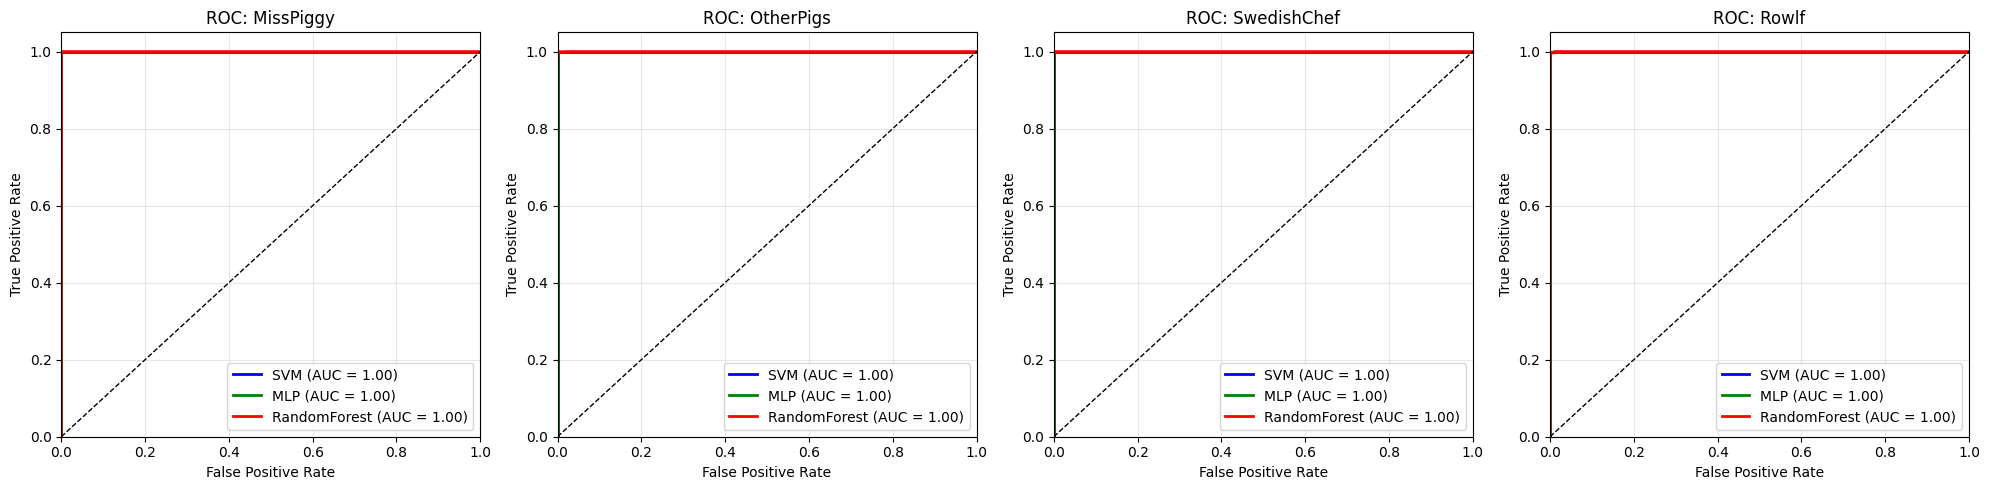

In [21]:
models = { 'SVM': cls_svm,  'MLP': cls_mlp, 'RandomForest': cls_rf }
plot_multiclass_roc(models, ds_visual_test_s, y_test_enc, CLASSES)